Analyze 15/149-150, 24/1-2 neq switching

In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import tqdm
import warnings
warnings.filterwarnings('ignore')
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole
import pandas as pd
import pickle

In [2]:
def bound_with_exp(forward_accumulated, reverse_accumulated):
    upper_dg, upper_ddg = pymbar.exp.EXP(forward_accumulated)
    lower_dg, lower_ddg = pymbar.exp.EXP(reverse_accumulated)
    return upper_dg, upper_ddg, lower_dg, lower_ddg
    
def analyze(forward_accumulated, reverse_accumulated): 
    # Compute dg, ddg
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    return dg, ddg

def analyze_bootstrap(d_works):
    d_dgs_phase = {}
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    d_dgs_phase['complex'] = (complex_dg, complex_ddg)
    d_dgs_phase['apo'] = (apo_dg, apo_ddg)
    
    binding_dg = complex_dg - apo_dg
#     binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
    return d_dgs_phase, binding_dg
    
def plot(forward_work, reverse_work, dg, ddg, dir_num, phase, output_dir, title):
#     # Substract offset
#     print("subtracting offset")
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)

    # Plot work trajectories
    print("plotting work trajs")
    for cycle in forward_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = cycle
        plt.plot(x, y, color=sns.color_palette()[0])
    for cycle in reverse_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = -cycle
        plt.plot(x, y, color=sns.color_palette()[1])
    plt.xlabel("$t_{neq}$ (ns)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_traj.png')}")
    plt.clf()
    
    # Plot work distributions
    print("plotting work distrib")
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward)
    sns.distplot(accumulated_reverse)
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
    plt.clf()

    return accumulated_forward
    

## 15/149

In [3]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 149
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print("binding DDG: ", complex_dg*KT_KCALMOL - apo_dg*KT_KCALMOL, " (", ((apo_ddg**2 + complex_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("complex DG: ", complex_dg*KT_KCALMOL, " (", complex_ddg*KT_KCALMOL,")")
    print("apo DG: ", apo_dg*KT_KCALMOL, " (", apo_ddg*KT_KCALMOL,")")
    
    complex_upper_dg, complex_upper_ddg, complex_lower_dg, complex_lower_ddg = bound_with_exp(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_upper_dg, apo_upper_ddg, apo_lower_dg, apo_lower_ddg = bound_with_exp(d_works['apo']['forward'], d_works['apo']['reverse'])
    print("binding DDG (upper): ", complex_upper_dg*KT_KCALMOL - apo_upper_dg*KT_KCALMOL, " (", ((apo_upper_ddg**2 + complex_upper_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("complex DG: ", complex_upper_dg*KT_KCALMOL, " (", complex_upper_ddg*KT_KCALMOL,")")
    print("apo DG: ", apo_upper_dg*KT_KCALMOL, " (", apo_upper_ddg*KT_KCALMOL,")")
    print("binding DDG (lower): ", complex_lower_dg*-KT_KCALMOL - apo_lower_dg*-KT_KCALMOL, " (", ((apo_lower_ddg**2 + complex_lower_ddg**2)**0.5)*-KT_KCALMOL, ")")
    print("complex DG: ", complex_lower_dg*-KT_KCALMOL, " (", complex_lower_ddg*-KT_KCALMOL,")")
    print("apo DG: ", apo_lower_dg*-KT_KCALMOL, " (", apo_lower_ddg*-KT_KCALMOL,")")
    

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 149
100
100
99
99
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/149/149_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/149/149_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/149/149_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/149/149_apo_work_dist.png
binding DDG:  4.721554469614404  ( 0.42313103479552544 )
complex DG:  71.75039274614743  ( 0.35033121910940057 )
apo DG:  67.02883827653302  ( 0.23729287710433564 )
binding DDG (upper):  4.20115390536337  ( 0.786306236106255 )
complex DG:  71.21658970942366  ( 0.5664598090793715 )
apo DG:  67.01543580406029  ( 0.545344644823205 )
binding DDG (lower):  4.904028897046899  ( -0.37190380029983355 )
complex DG:  70.59275963424383  ( -0.2819001208357336 )
apo DG:  65.68873073719693  ( -0.24257938607857274 )


<Figure size 432x288 with 0 Axes>

(array([ 7.,  9., 16., 21., 22., 10.,  1.,  4.,  4.,  6.]),
 array([ 75.69219395,  80.32654422,  84.9608945 ,  89.59524478,
         94.22959505,  98.86394533, 103.49829561, 108.13264589,
        112.76699616, 117.40134644, 122.03569672]),
 <BarContainer object of 10 artists>)

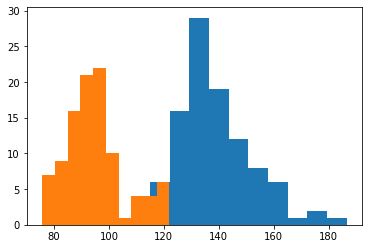

In [4]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [5]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[4.63, (2.97, 5.74)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [10]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

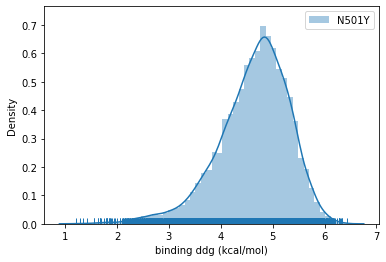

In [11]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [12]:
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.6901115632332547

In [13]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [14]:
output_kcalmol_apo

[67.03, (66.6, 67.47)]

In [15]:
output_kcalmol_complex

[71.66, (70.01, 72.68)]

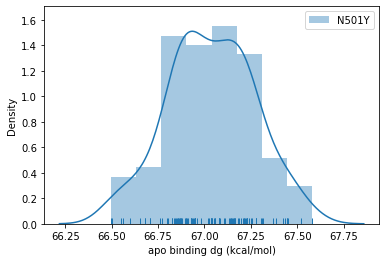

In [16]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

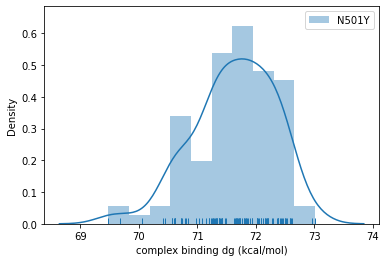

In [17]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/150

In [42]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 150
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print("binding DDG: ", complex_dg*KT_KCALMOL - apo_dg*KT_KCALMOL, " (", ((apo_ddg**2 + complex_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("\tcomplex DG: ", complex_dg*KT_KCALMOL, " (", complex_ddg*KT_KCALMOL,")")
    print("\tapo DG: ", apo_dg*KT_KCALMOL, " (", apo_ddg*KT_KCALMOL,")")
    
    complex_upper_dg, complex_upper_ddg, complex_lower_dg, complex_lower_ddg = bound_with_exp(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_upper_dg, apo_upper_ddg, apo_lower_dg, apo_lower_ddg = bound_with_exp(d_works['apo']['forward'], d_works['apo']['reverse'])
    print("binding DDG (upper): ", complex_upper_dg*KT_KCALMOL - apo_upper_dg*KT_KCALMOL, " (", ((apo_upper_ddg**2 + complex_upper_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("\tcomplex DG: ", complex_upper_dg*KT_KCALMOL, " (", complex_upper_ddg*KT_KCALMOL,")")
    print("\tapo DG: ", apo_upper_dg*KT_KCALMOL, " (", apo_upper_ddg*KT_KCALMOL,")")
    print("binding DDG (lower): ", complex_lower_dg*-KT_KCALMOL - apo_lower_dg*-KT_KCALMOL, " (", ((apo_lower_ddg**2 + complex_lower_ddg**2)**0.5)*-KT_KCALMOL, ")")
    print("\tcomplex DG: ", complex_lower_dg*-KT_KCALMOL, " (", complex_lower_ddg*-KT_KCALMOL,")")
    print("\tapo DG: ", apo_lower_dg*-KT_KCALMOL, " (", apo_lower_ddg*-KT_KCALMOL,")")
     

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 150
99
99
98
98
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/150/150_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/150/150_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/150/150_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/150/150_apo_work_dist.png
binding DDG:  -3.9610224174645907  ( 0.6753657059105256 )
	complex DG:  64.53126750109818  ( 0.5757890532515573 )
	apo DG:  68.49228991856278  ( 0.35296714135411805 )
binding DDG (upper):  -1.639998829018353  ( 0.60748393938898 )
	complex DG:  69.9967749932545  ( 0.522653026751646 )
	apo DG:  71.63677382227286  ( 0.3096296985802509 )
binding DDG (lower):  -6.237395963332304  ( -0.3052733803246995 )
	complex DG:  59.06206190831544  ( -0.24264641827796635 )
	apo DG:  65.29945787164775  ( -0.1852418754810662 )


<Figure size 432x288 with 0 Axes>

(array([ 2.,  1.,  5., 11., 10., 12., 20., 20., 10.,  8.]),
 array([ 71.75184969,  74.81692845,  77.88200721,  80.94708597,
         84.01216473,  87.07724349,  90.14232225,  93.20740101,
         96.27247977,  99.33755853, 102.40263729]),
 <BarContainer object of 10 artists>)

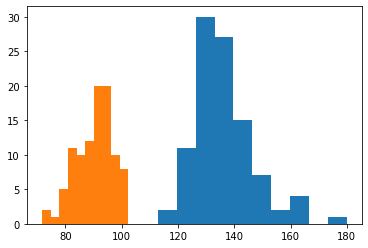

In [43]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [44]:
np.min(d_works['complex']['forward'])

112.95256998522191

In [46]:
for i, work, in enumerate(d_works['complex']['forward']):
    if work < 120:
        print(i, work)

36 112.95256998522191
66 114.89642486473606


In [21]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [23]:
output_kcalmol

[-3.69, (-4.7, -1.65)]

In [24]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [25]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [26]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

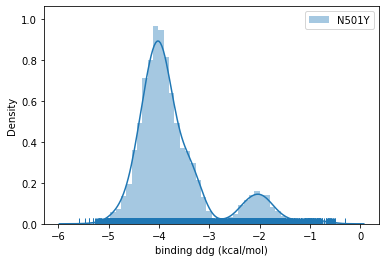

In [27]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [28]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.7985531211368272

In [29]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [30]:
output_kcalmol_apo

[68.53, (68.14, 69.1)]

In [31]:
output_kcalmol_complex

[64.83, (64.05, 66.74)]

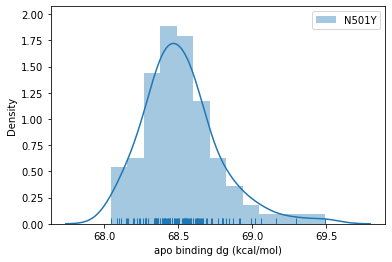

In [32]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

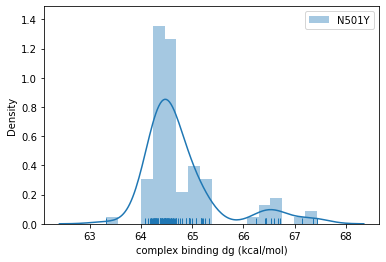

In [33]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 24/1

In [6]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 25
forward = 1
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print("binding DDG: ", complex_dg*KT_KCALMOL - apo_dg*KT_KCALMOL, " (", ((apo_ddg**2 + complex_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("complex DG: ", complex_dg*KT_KCALMOL, " (", complex_ddg*KT_KCALMOL,")")
    print("apo DG: ", apo_dg*KT_KCALMOL, " (", apo_ddg*KT_KCALMOL,")")
    
    complex_upper_dg, complex_upper_ddg, complex_lower_dg, complex_lower_ddg = bound_with_exp(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_upper_dg, apo_upper_ddg, apo_lower_dg, apo_lower_ddg = bound_with_exp(d_works['apo']['forward'], d_works['apo']['reverse'])
    print("binding DDG (upper): ", complex_upper_dg*KT_KCALMOL - apo_upper_dg*KT_KCALMOL, " (", ((apo_upper_ddg**2 + complex_upper_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("complex DG: ", complex_upper_dg*KT_KCALMOL, " (", complex_upper_ddg*KT_KCALMOL,")")
    print("apo DG: ", apo_upper_dg*KT_KCALMOL, " (", apo_upper_ddg*KT_KCALMOL,")")
    print("binding DDG (lower): ", complex_lower_dg*-KT_KCALMOL - apo_lower_dg*-KT_KCALMOL, " (", ((apo_lower_ddg**2 + complex_lower_ddg**2)**0.5)*-KT_KCALMOL, ")")
    print("complex DG: ", complex_lower_dg*-KT_KCALMOL, " (", complex_lower_ddg*-KT_KCALMOL,")")
    print("apo DG: ", apo_lower_dg*-KT_KCALMOL, " (", apo_lower_ddg*-KT_KCALMOL,")")
    

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 1
99
99
100
100
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/25/1/1_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/25/1/1_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/25/1/1_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/25/1/1_apo_work_dist.png
binding DDG:  3.8079987318618578  ( 0.42996374176297586 )
complex DG:  70.24157657959996  ( 0.36925303154265543 )
apo DG:  66.4335778477381  ( 0.2202748690327104 )
binding DDG (upper):  4.271096511455312  ( 0.5404131420378274 )
complex DG:  71.14423762178308  ( 0.3728835634415452 )
apo DG:  66.87314111032777  ( 0.39115752862795844 )
binding DDG (lower):  4.6812088507602  ( -0.5809978020511373 )
complex DG:  70.09212613480427  ( -0.5210170588993266 )
apo DG:  65.41091728404407  ( -0.25709856149762506 )


<Figure size 432x288 with 0 Axes>

(array([ 2.,  5., 14., 28., 22., 12.,  6.,  3.,  3.,  4.]),
 array([ 71.04062433,  76.14007755,  81.23953078,  86.33898401,
         91.43843723,  96.53789046, 101.63734369, 106.73679691,
        111.83625014, 116.93570337, 122.03515659]),
 <BarContainer object of 10 artists>)

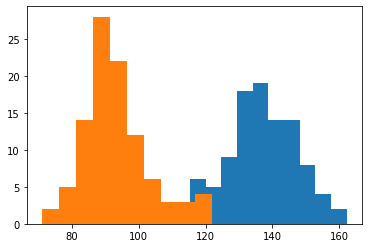

In [7]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [8]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [10]:
output_kcalmol

[3.82, (2.53, 5.26)]

In [10]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [11]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [12]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

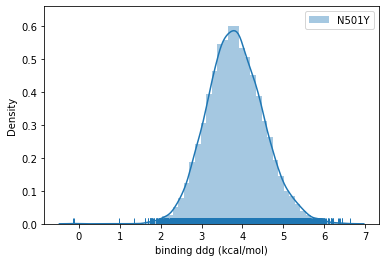

In [13]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [14]:
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.6937722630370233

In [15]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [16]:
output_kcalmol_apo

[66.44, (66.0, 66.89)]

In [17]:
output_kcalmol_complex

[70.27, (69.05, 71.63)]

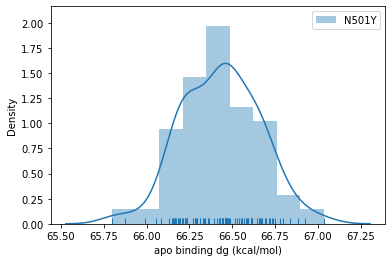

In [18]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

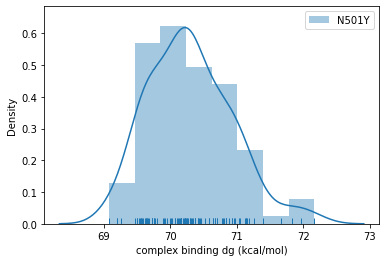

In [19]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 24/2

In [36]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 25
forward = 2
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print("binding DDG: ", complex_dg*KT_KCALMOL - apo_dg*KT_KCALMOL, " (", ((apo_ddg**2 + complex_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("\tcomplex DG: ", complex_dg*KT_KCALMOL, " (", complex_ddg*KT_KCALMOL,")")
    print("\tapo DG: ", apo_dg*KT_KCALMOL, " (", apo_ddg*KT_KCALMOL,")")
    
    complex_upper_dg, complex_upper_ddg, complex_lower_dg, complex_lower_ddg = bound_with_exp(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_upper_dg, apo_upper_ddg, apo_lower_dg, apo_lower_ddg = bound_with_exp(d_works['apo']['forward'], d_works['apo']['reverse'])
    print("binding DDG (upper): ", complex_upper_dg*KT_KCALMOL - apo_upper_dg*KT_KCALMOL, " (", ((apo_upper_ddg**2 + complex_upper_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("\tcomplex DG: ", complex_upper_dg*KT_KCALMOL, " (", complex_upper_ddg*KT_KCALMOL,")")
    print("\tapo DG: ", apo_upper_dg*KT_KCALMOL, " (", apo_upper_ddg*KT_KCALMOL,")")
    print("binding DDG (lower): ", complex_lower_dg*-KT_KCALMOL - apo_lower_dg*-KT_KCALMOL, " (", ((apo_lower_ddg**2 + complex_lower_ddg**2)**0.5)*-KT_KCALMOL, ")")
    print("\tcomplex DG: ", complex_lower_dg*-KT_KCALMOL, " (", complex_lower_ddg*-KT_KCALMOL,")")
    print("\tapo DG: ", apo_lower_dg*-KT_KCALMOL, " (", apo_lower_ddg*-KT_KCALMOL,")")
     

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 2
99
99
100
100
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/25/2/2_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/25/2/2_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/25/2/2_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/25/2/2_apo_work_dist.png
binding DDG:  -1.7440945814855269  ( 0.7063851634408682 )
	complex DG:  65.08638661573258  ( 0.6505661875339881 )
	apo DG:  66.8304811972181  ( 0.27521561504913566 )
binding DDG (upper):  -0.23720411880252357  ( 0.6138313425209485 )
	complex DG:  67.64123585044366  ( 0.5177411929363367 )
	apo DG:  67.87843996924619  ( 0.32974683349189104 )
binding DDG (lower):  -2.9945392986270463  ( -0.6091840896598182 )
	complex DG:  62.533922240653524  ( -0.5166853672763279 )
	apo DG:  65.52846153928057  ( -0.32270960062754195 )


<Figure size 432x288 with 0 Axes>

(array([ 1.,  4., 13., 14., 21., 14., 12., 11.,  7.,  2.]),
 array([ 73.38057741,  76.97726459,  80.57395176,  84.17063893,
         87.7673261 ,  91.36401327,  94.96070044,  98.55738762,
        102.15407479, 105.75076196, 109.34744913]),
 <BarContainer object of 10 artists>)

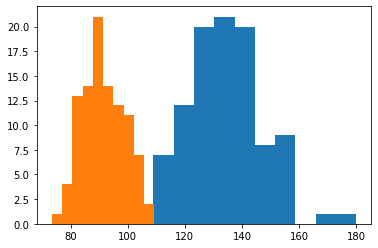

In [39]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [40]:
for i, work in enumerate(d_works['complex']['forward']):
    if work < 115:
        print(i, work)

31 112.43682441200434
33 113.53289647072529
38 111.93745962983006
76 112.06771799790008
87 109.00364527074476


In [38]:
np.min(d_works['complex']['forward'])

109.00364527074476

In [25]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [26]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [27]:
output_kcalmol

[-1.78, (-3.08, -0.53)]

In [28]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [29]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [30]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

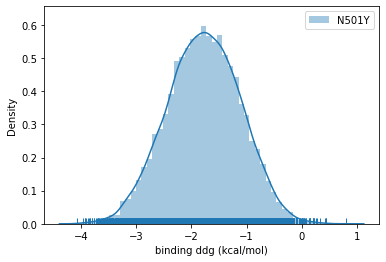

In [31]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [32]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.6592393868640255

In [33]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [34]:
output_kcalmol_apo

[66.85, (66.33, 67.44)]

In [35]:
output_kcalmol_complex

[65.07, (63.91, 66.16)]

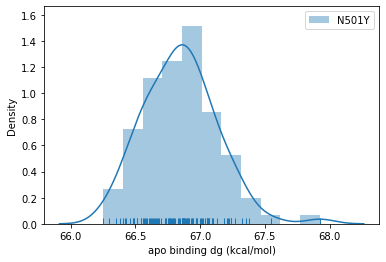

In [36]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

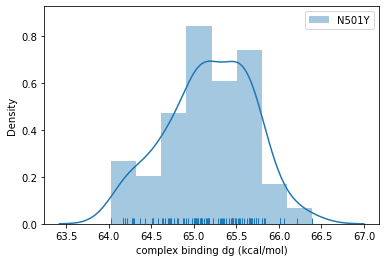

In [37]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()